# Validate last 78 5 minutes GOOG Close price

### Download 30 days 5 minutes time frame of GOOG stock prices

In [1]:
# import yfinance as yf
# import pandas as pd

# # Download GOOG stock data at 5-minute intervals for the past 30 days
# df = yf.download(tickers='GOOG', period='30d', interval='5m')

# # Flatten columns if multi-indexed
# if isinstance(df.columns, pd.MultiIndex):
#     df.columns = df.columns.get_level_values(0)

# # Convert index (Datetime) from UTC to US/Eastern
# df.index = df.index.tz_convert('US/Eastern')

# # Preview the DataFrame
# print(df.head())

# # Optional: Save to CSV
# df.to_csv('goog_30days_5min.csv')

### Using LSTM to compare forecast and actual last 78 5 minutes data with single feature

Epoch 1/20, Loss: 0.027609
Epoch 2/20, Loss: 0.021652
Epoch 3/20, Loss: 0.016207
Epoch 4/20, Loss: 0.006115
Epoch 5/20, Loss: 0.004752
Epoch 6/20, Loss: 0.003841
Epoch 7/20, Loss: 0.003023
Epoch 8/20, Loss: 0.004522
Epoch 9/20, Loss: 0.003897
Epoch 10/20, Loss: 0.004801
Epoch 11/20, Loss: 0.002804
Epoch 12/20, Loss: 0.003946
Epoch 13/20, Loss: 0.002845
Epoch 14/20, Loss: 0.003662
Epoch 15/20, Loss: 0.002649
Epoch 16/20, Loss: 0.002755
Epoch 17/20, Loss: 0.002347
Epoch 18/20, Loss: 0.003823
Epoch 19/20, Loss: 0.002575
Epoch 20/20, Loss: 0.003383
Saved comparison to goog_forecast_vs_actual.csv
Validation MAE : 0.4355
Validation MSE : 0.3685
Validation RMSE: 0.6071
Validation R²  : -0.5653


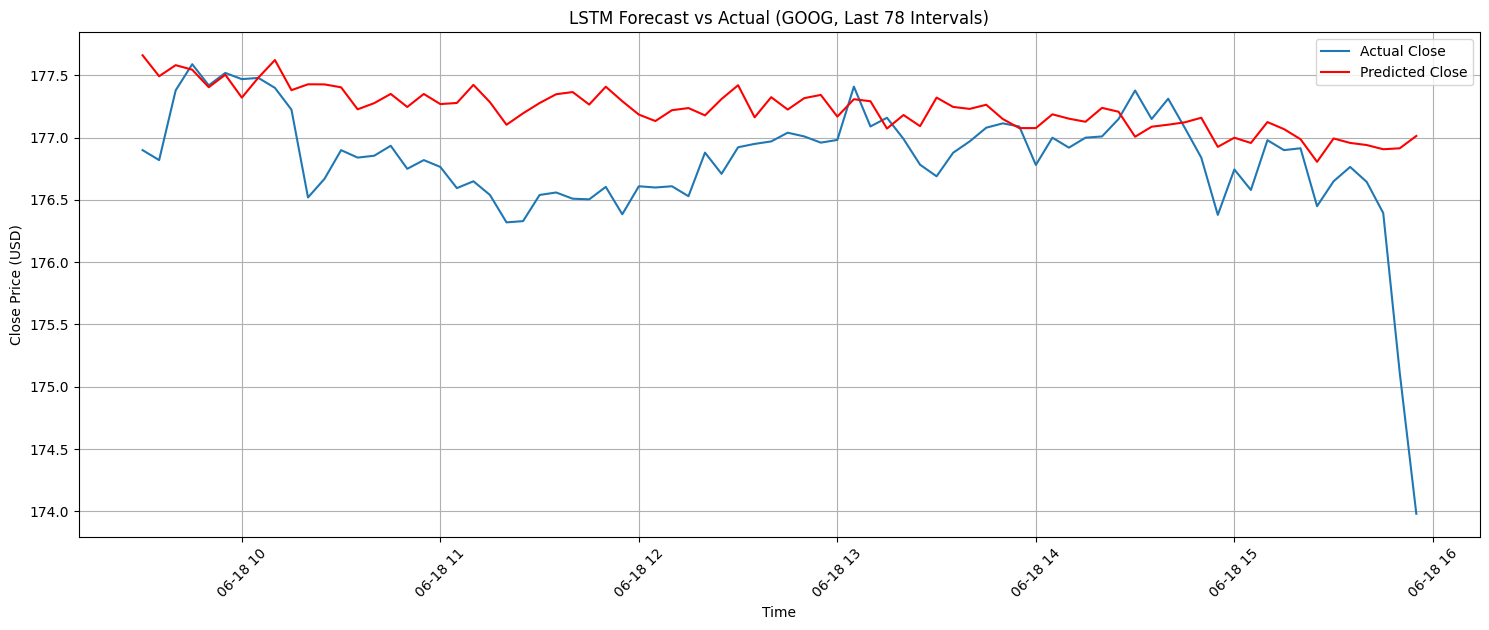

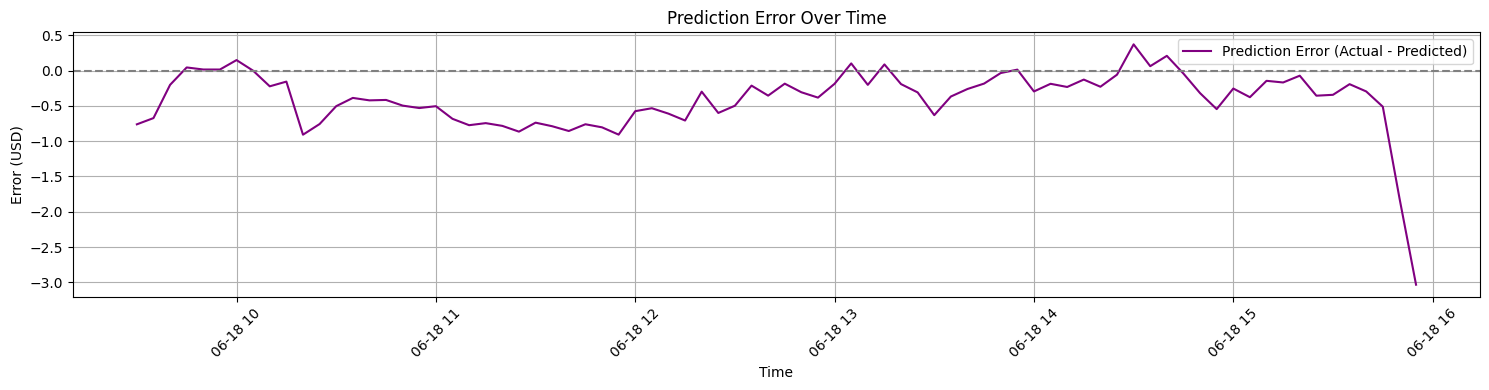

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# Step 1: Load and preprocess
# -----------------------------
df = pd.read_csv("goog_30days_5min.csv", parse_dates=['Datetime'], index_col='Datetime')
close_prices = df['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_prices)

# -----------------------------
# Step 2: Prepare sequences
# -----------------------------
INPUT_LEN = 78 * 3  # past 3 trading days
OUTPUT_LEN = 78     # forecast next 1 trading day (5-minute steps)

X = []
Y = []

for i in range(len(scaled_close) - INPUT_LEN - OUTPUT_LEN):
    X.append(scaled_close[i:i+INPUT_LEN])
    Y.append(scaled_close[i+INPUT_LEN:i+INPUT_LEN+OUTPUT_LEN])

X = np.array(X)
Y = np.array(Y)

X_tensor = torch.tensor(X, dtype=torch.float32)  # shape: (N, 234, 1)
Y_tensor = torch.tensor(Y, dtype=torch.float32)  # shape: (N, 78)

# -----------------------------
# Step 3: Define LSTM model
# -----------------------------
class LSTMForecast(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_len=78):
        super(LSTMForecast, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_len)

    def forward(self, x):
        out, _ = self.lstm(x)           # out: (batch, seq_len, hidden)
        out = out[:, -1, :]             # use last time step's output
        out = self.fc(out)              # project to output_len (78)
        return out

# Instantiate model
model = LSTMForecast()

# -----------------------------
# Step 4: Training loop
# -----------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 20
BATCH_SIZE = 64

for epoch in range(EPOCHS):
    permutation = torch.randperm(X_tensor.size(0))
    for i in range(0, X_tensor.size(0), BATCH_SIZE):
        indices = permutation[i:i + BATCH_SIZE]
        batch_x = X_tensor[indices]
        batch_y = Y_tensor[indices]

        output = model(batch_x)
        loss = criterion(output, batch_y.squeeze(-1))  # 🔧 Fix here

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {loss.item():.6f}")

# -----------------------------
# Step 5: Forecast next 78 steps
# -----------------------------
model.eval()  # 🔍 Set model to evaluation mode

# Use last 234 data points to predict the next 78
last_input = torch.tensor(scaled_close[-(INPUT_LEN + OUTPUT_LEN):-OUTPUT_LEN], dtype=torch.float32).unsqueeze(0)  # (1, 234, 1)

with torch.no_grad():
    forecast_scaled = model(last_input).numpy().flatten()

forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()

# -----------------------------
# Step 6: Prepare ground truth
# -----------------------------
actual = close_prices[-OUTPUT_LEN:].flatten()

# -----------------------------
# Step 7: Save forecast vs actual to CSV
# -----------------------------
df_compare = pd.DataFrame({
    'Datetime': df.index[-OUTPUT_LEN:],  # last 78 timestamps
    'Actual_Close': actual,
    'Predicted_Close': forecast
})

df_compare.to_csv("goog_forecast_vs_actual_single_feature.csv", index=False)
print("Saved comparison to goog_forecast_vs_actual.csv")

# -----------------------------
# Step 7.5: Calculate metrics
# -----------------------------

actual_vals = df_compare['Actual_Close'].values
predicted_vals = df_compare['Predicted_Close'].values

mae = mean_absolute_error(actual_vals, predicted_vals)
mse = mean_squared_error(actual_vals, predicted_vals)
rmse = np.sqrt(mse)
r2 = r2_score(actual_vals, predicted_vals)

print(f"Validation MAE : {mae:.4f}")
print(f"Validation MSE : {mse:.4f}")
print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation R²  : {r2:.4f}")

# Save metrics to a text file
with open("forecast_metrics_single_feature.txt", "w") as f:
    f.write(f"Validation MAE : {mae:.4f}\n")
    f.write(f"Validation MSE : {mse:.4f}\n")
    f.write(f"Validation RMSE: {rmse:.4f}\n")
    f.write(f"Validation R²  : {r2:.4f}\n")

# -----------------------------
# Step 8: Plot the comparison
# -----------------------------
plt.figure(figsize=(15, 6))
plt.plot(df_compare['Datetime'], df_compare['Actual_Close'], label='Actual Close')
plt.plot(df_compare['Datetime'], df_compare['Predicted_Close'], label='Predicted Close', color='red')
plt.xlabel('Time')
plt.ylabel('Close Price (USD)')
plt.title('LSTM Forecast vs Actual (GOOG, Last 78 Intervals)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# -----------------------------
# Step 9: Plot Error Over Time
# -----------------------------
error = df_compare['Actual_Close'] - df_compare['Predicted_Close']

plt.figure(figsize=(15, 4))
plt.plot(df_compare['Datetime'], error, label='Prediction Error (Actual - Predicted)', color='purple')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Time')
plt.ylabel('Error (USD)')
plt.title('Prediction Error Over Time')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Using LSTM to compare forecast and actual last 78 5 minutes data with multi features

Epoch 1/20, Loss: 0.032590
Epoch 2/20, Loss: 0.015271
Epoch 3/20, Loss: 0.004849
Epoch 4/20, Loss: 0.004306
Epoch 5/20, Loss: 0.002764
Epoch 6/20, Loss: 0.004369
Epoch 7/20, Loss: 0.002830
Epoch 8/20, Loss: 0.003091
Epoch 9/20, Loss: 0.003248
Epoch 10/20, Loss: 0.002684
Epoch 11/20, Loss: 0.004522
Epoch 12/20, Loss: 0.004080
Epoch 13/20, Loss: 0.002836
Epoch 14/20, Loss: 0.003115
Epoch 15/20, Loss: 0.002911
Epoch 16/20, Loss: 0.003247
Epoch 17/20, Loss: 0.002780
Epoch 18/20, Loss: 0.002558
Epoch 19/20, Loss: 0.002672
Epoch 20/20, Loss: 0.003049
Saved comparison to goog_forecast_vs_actual.csv
Validation MAE : 0.4769
Validation MSE : 0.4407
Validation RMSE: 0.6639
Validation R²  : -0.8721


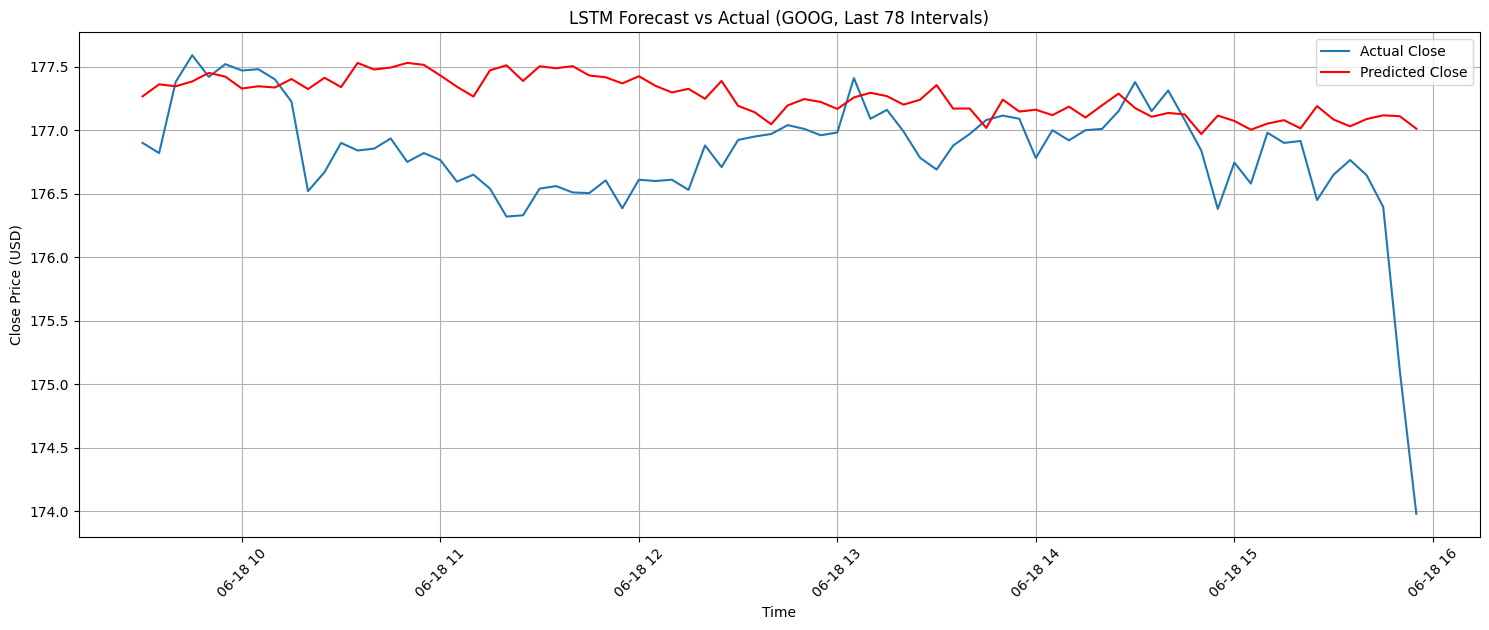

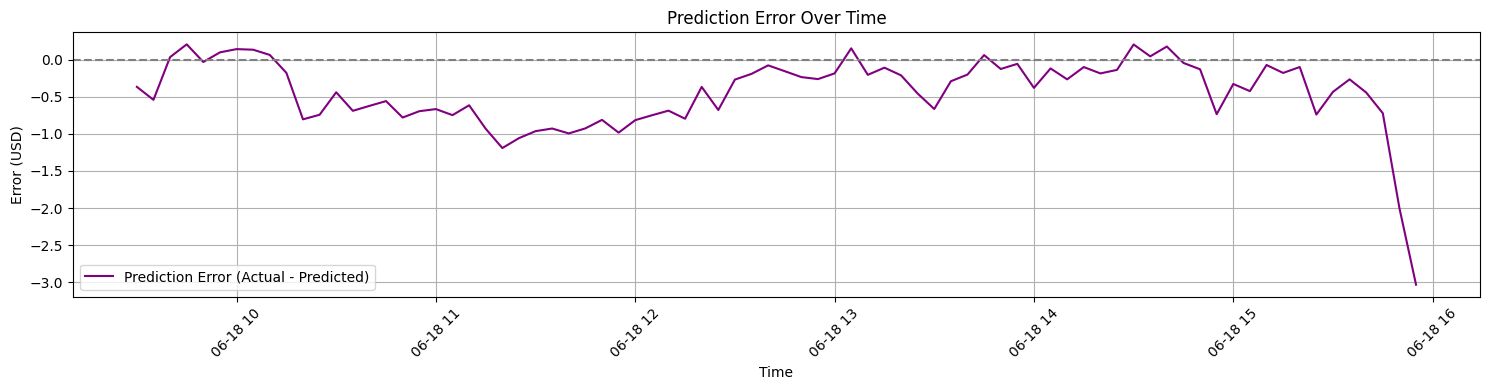

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -------------------------------------
# Step 1: Load and preprocess the data
# -------------------------------------
df = pd.read_csv("goog_30days_5min.csv", parse_dates=['Datetime'], index_col='Datetime')
features = ['Close', 'High', 'Low', 'Open', 'Volume']
data = df[features].values

# Normalize all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Save index of Close column for inverse transform later
close_index = features.index('Close')

# -------------------------------------
# Step 2: Prepare sequences
# -------------------------------------
INPUT_LEN = 78 * 3   # past 3 trading days
OUTPUT_LEN = 78      # future 1 trading day

X = []
Y = []

for i in range(len(scaled_data) - INPUT_LEN - OUTPUT_LEN):
    X.append(scaled_data[i:i+INPUT_LEN])
    Y.append(scaled_data[i+INPUT_LEN:i+INPUT_LEN+OUTPUT_LEN, close_index])

X = np.array(X)
Y = np.array(Y)

X_tensor = torch.tensor(X, dtype=torch.float32)       # (N, 234, 5)
Y_tensor = torch.tensor(Y, dtype=torch.float32)       # (N, 78)

# -------------------------------------
# Step 3: Define the LSTM model
# -------------------------------------
class MultiFeatureLSTM(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2, output_len=78):
        super(MultiFeatureLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_len)

    def forward(self, x):
        out, _ = self.lstm(x)          # (batch, seq, hidden)
        out = out[:, -1, :]            # last timestep
        out = self.fc(out)             # (batch, 78)
        return out

model = MultiFeatureLSTM()

# -------------------------------------
# Step 4: Training loop
# -------------------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 20
BATCH_SIZE = 64

for epoch in range(EPOCHS):
    permutation = torch.randperm(X_tensor.size(0))
    for i in range(0, X_tensor.size(0), BATCH_SIZE):
        indices = permutation[i:i+BATCH_SIZE]
        batch_x = X_tensor[indices]
        batch_y = Y_tensor[indices]

        output = model(batch_x)
        loss = criterion(output, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.6f}")

# -----------------------------
# Step 5: Forecast next 78 steps
# -----------------------------
model.eval()

# Use last 234 rows to forecast next 78 steps
last_input = torch.tensor(scaled_data[-(INPUT_LEN + OUTPUT_LEN):-OUTPUT_LEN], dtype=torch.float32).unsqueeze(0)  # (1, 234, 5)

with torch.no_grad():
    forecast_scaled = model(last_input).numpy().flatten()

# Inverse transform only the Close column
dummy = np.zeros((forecast_scaled.shape[0], len(features)))
dummy[:, close_index] = forecast_scaled
forecast = scaler.inverse_transform(dummy)[:, close_index]

# -----------------------------
# Step 6: Prepare ground truth
# -----------------------------
actual = data[-OUTPUT_LEN:, close_index]  # raw unscaled close prices

# -----------------------------
# Step 7: Save forecast vs actual to CSV
# -----------------------------
df_compare = pd.DataFrame({
    'Datetime': df.index[-OUTPUT_LEN:],  # last 78 timestamps
    'Actual_Close': actual,
    'Predicted_Close': forecast
})

df_compare.to_csv("goog_forecast_vs_actual_multi_features.csv", index=False)
print("Saved comparison to goog_forecast_vs_actual.csv")

# -----------------------------
# Step 7.5: Calculate metrics
# -----------------------------
actual_vals = df_compare['Actual_Close'].values
predicted_vals = df_compare['Predicted_Close'].values

mae = mean_absolute_error(actual_vals, predicted_vals)
mse = mean_squared_error(actual_vals, predicted_vals)
rmse = np.sqrt(mse)
r2 = r2_score(actual_vals, predicted_vals)

print(f"Validation MAE : {mae:.4f}")
print(f"Validation MSE : {mse:.4f}")
print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation R²  : {r2:.4f}")

# Save metrics to a text file
with open("forecast_metrics_multi_features.txt", "w") as f:
    f.write(f"Validation MAE : {mae:.4f}\n")
    f.write(f"Validation MSE : {mse:.4f}\n")
    f.write(f"Validation RMSE: {rmse:.4f}\n")
    f.write(f"Validation R²  : {r2:.4f}\n")

# -----------------------------
# Step 8: Plot the comparison
# -----------------------------
plt.figure(figsize=(15, 6))
plt.plot(df_compare['Datetime'], df_compare['Actual_Close'], label='Actual Close')
plt.plot(df_compare['Datetime'], df_compare['Predicted_Close'], label='Predicted Close', color='red')
plt.xlabel('Time')
plt.ylabel('Close Price (USD)')
plt.title('LSTM Forecast vs Actual (GOOG, Last 78 Intervals)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# -----------------------------
# Step 9: Plot Error Over Time
# -----------------------------
error = df_compare['Actual_Close'] - df_compare['Predicted_Close']

plt.figure(figsize=(15, 4))
plt.plot(df_compare['Datetime'], error, label='Prediction Error (Actual - Predicted)', color='purple')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Time')
plt.ylabel('Error (USD)')
plt.title('Prediction Error Over Time')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()